Este trabalho visa o uso de CNN (Convolucional Neural Network) para identificação de imagens de de pintas de pele
classificadas e rotuladas que serão avaliadas pela rede sendo câncer benigno, indeterminado benignigo, indeterminado malígno, câncer maligno ou não determinado.

Foi construido um modelo que usa imagens de pintas de pele como entrada e produz a probabilidade 
prevista para cada uma das categorias.

Na primeira aprendizagem foi usada rede de 38 camadas e na segunda foi usada rede de 50 camadas para se obter melhor resultado.




In [1]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline


Foram importados todos os pacotes necessários e, também usada a biblioteca FastAI V1 que 
fornece várias funções que permitem a construção de uma rede neural fácil e eficiente. 
A biblioteca FastAI V1 fica no topo Pytorch 1.0. 





In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.metrics import accuracy
from IPython.display import clear_output, display, HTML
import pandas as pd

# Esta linha é uma solução caso haja erro ao visualizar quadros de dados
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""



In [3]:
bs = 64


Foi usado Data Set de imagens do endereço: https://www.isic-archive.com e salvo em um diretório local.




In [4]:
path = Path('/Users/aguida/transf')


In [5]:
path.ls()


[PosixPath('/Users/aguida/transf/.DS_Store'),
 PosixPath('/Users/aguida/transf/JSON'),
 PosixPath('/Users/aguida/transf/IMAGENS')]

In [6]:
path_img = path/'IMAGENS'


In [7]:

fnames = get_image_files(path_img)
fnames[:5]


[PosixPath('/Users/aguida/transf/IMAGENS/BENIGNO_0000012.jpg'),
 PosixPath('/Users/aguida/transf/IMAGENS/BENIGNO_0000774.jpg'),
 PosixPath('/Users/aguida/transf/IMAGENS/BENIGNO_0000760.jpg'),
 PosixPath('/Users/aguida/transf/IMAGENS/MALIGNO_0000316.jpg'),
 PosixPath('/Users/aguida/transf/IMAGENS/BENIGNO_0000006.jpg')]

In [8]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'


In [35]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)


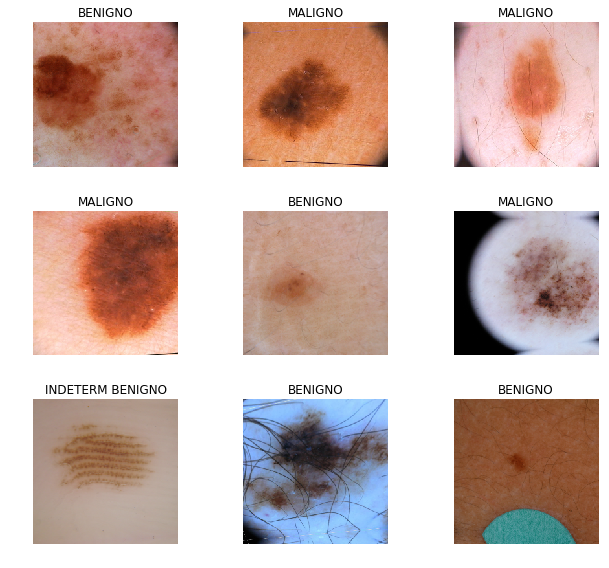

In [36]:
data.show_batch(rows=3, figsize=(9,8))


In [11]:
print(data.classes)
len(data.classes),data.c


['BENIGNO', 'INDETERM BENIGNO', 'INDETERM MALIGNO', 'MALIGNO', 'NAO DETERMINADO']


(5, 5)

Agora mediremos a acurácia de um ciclo com 4 epocas em uma rede de 34 camadas:


In [12]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)


In [13]:
learn.fit_one_cycle(4)


epoch,train_loss,valid_loss,accuracy,time
0,1.968783,0.965455,0.610294,06:24
1,1.670423,0.945118,0.727941,05:36
2,1.397213,0.784940,0.808824,05:45
3,1.235605,0.738089,0.801471,06:01


In [14]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)


In [15]:
learn.save('stage-1')


In [16]:
# Resultados:

interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)


True

Resultado - MATRIZ DE CONFUSAO




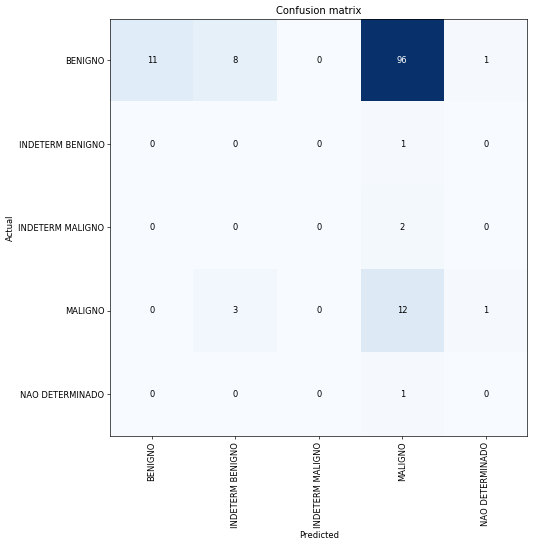

In [17]:
interp.plot_confusion_matrix(figsize=(9,9), dpi=60)

In [18]:
interp.most_confused(min_val=2)

[('BENIGNO', 'MALIGNO', 96),
 ('BENIGNO', 'INDETERM BENIGNO', 8),
 ('MALIGNO', 'INDETERM BENIGNO', 3),
 ('INDETERM MALIGNO', 'MALIGNO', 2)]

Resultado - As 9 imagens com mais perda

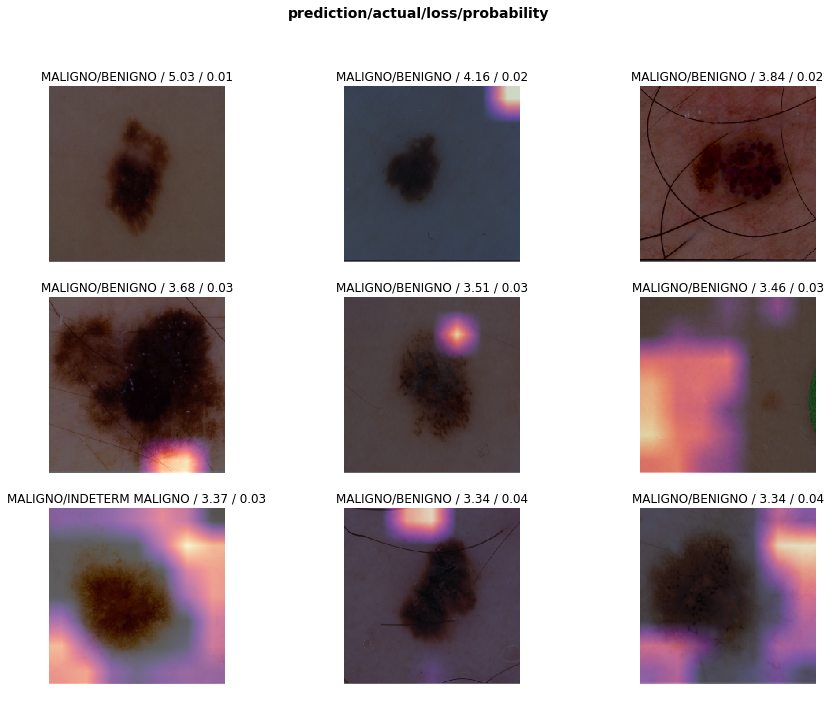

In [19]:

interp.plot_top_losses(9, figsize=(15,11))


O modelo está funcionando como esperado, descongelaremos o modelo e treinamos um pouco mais.



In [20]:
learn.unfreeze()

In [21]:
learn.fit_one_cycle(1)


epoch,train_loss,valid_loss,error_rate,time
0,1.872938,5.185529,0.897059,07:40


In [22]:
learn.load('stage-1');


In [23]:
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


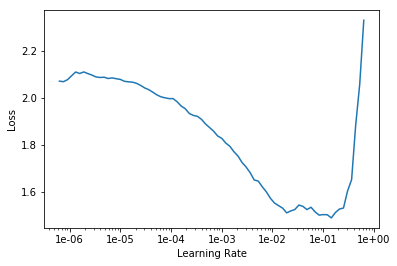

In [24]:
learn.recorder.plot()


In [25]:

learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))


epoch,train_loss,valid_loss,error_rate,time
0,2.001079,1.791013,0.808824,08:04
1,1.959323,1.717128,0.750000,08:59


Até aqui foi rodada Resnet34 que é uma rede residual de 34 camadas. Agora vamos rodar resnet50 com 50 camadas.

O resnet50 geralmente funciona melhor porque é uma rede mais profunda com mais parâmetros. 

O objetivo é conseguir um desempenho melhor aqui.

Os dados foram normalizados e será medida a acurácia do modelo.





In [26]:

data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [27]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


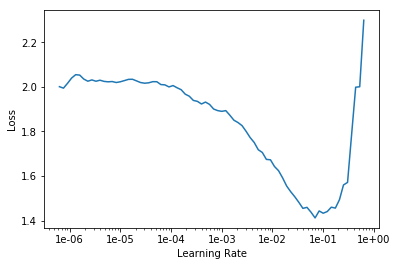

In [28]:
learn.lr_find()
learn.recorder.plot()


Rodamos mais um ciclo de aprendizagem com 8 épocas para medir a acurácia:



In [29]:
learn.fit_one_cycle(8)


epoch,train_loss,valid_loss,accuracy,time
0,1.718804,1.288070,0.514706,15:31
1,1.339184,1.063452,0.698529,15:32
2,1.003378,0.639368,0.794118,14:57
3,0.736402,0.463357,0.867647,16:14
4,0.557356,0.446919,0.875000,16:12
5,0.437324,0.456610,0.875000,14:19
6,0.351068,0.463798,0.889706,14:20
7,0.286273,0.450218,0.889706,14:30


In [30]:
learn.save('stage-1-50')


In [31]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))


epoch,train_loss,valid_loss,accuracy,time
0,0.146519,0.442372,0.882353,18:40
1,0.142887,0.418876,0.882353,18:35
2,0.139959,0.421682,0.889706,18:40
3,0.131962,0.418935,0.897059,18:46


In [32]:
learn.load('stage-1-50');


In [33]:
interp = ClassificationInterpretation.from_learner(learn)


In [34]:
interp.most_confused(min_val=2)


[('INDETERM BENIGNO', 'BENIGNO', 4),
 ('MALIGNO', 'BENIGNO', 4),
 ('BENIGNO', 'MALIGNO', 3),
 ('MALIGNO', 'INDETERM MALIGNO', 2)]